# Projeto Inteligencia Computacional - Regressão Linear Bolsa de Valores
O objetivo do projeto é tenta prever um valor futuro no atributo "close"

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend as K
import matplotlib.dates as dates
from sklearn.preprocessing import MinMaxScaler
import requests

## Coleta dos dados
Fonte: https://www.barchart.com/ondemand

In [4]:

urlPost = "https://marketdata.websol.barchart.com/getHistory.csv?apikey=958bd129b997922724b5242bdcc8cf9d&symbol=IBM&type=minutes&startDate=20200101&endDate=20200201&interval=60&order=asc&sessionFilter=EFK&splits=true÷nds=true&volume=sum&nearby=1&jerq=true"

myobj = {
    'apikey':'958bd129b997922724b5242bdcc8cf9d',
}

x = requests.post(urlPost, data = myobj)

f = open("dataset2.csv", "w")
f.write(x.text)
f.close()

In [5]:
urlPost = "https://marketdata.websol.barchart.com/getHistory.csv"

In [6]:
dataframe = pd.read_csv("dataset.csv") 

## Análise dos dados

Olhando para os cinco primeiros dados

In [7]:
dataframe[0:5]

,symbol,timestamp,tradingDay,open,high,low,close,volume
0,GOOG,11/05/2020 11:45,11/05/2020,13996,13996,139829,1399037,7567
1,GOOG,11/05/2020 11:50,11/05/2020,139892,139939,1398323,139879,3968
2,GOOG,11/05/2020 11:55,11/05/2020,139891,139952,139846,139952,4819
3,GOOG,11/05/2020 12:00,11/05/2020,139906,139967,1399,139909,5142
4,GOOG,11/05/2020 12:05,11/05/2020,139943,139977,13981,13981,11500


Descrição mais detalhado dos dados

In [8]:
dataframe.describe()

,open,high,low,close,volume
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,4.396000e+05,3.608101e+05,3.566961e+05,5.028537e+05,11668.873000
std,5.532629e+05,5.040311e+05,5.006725e+05,5.851585e+05,16413.958367
min,1.335000e+03,1.336000e+03,1.339000e+03,1.330000e+03,1885.000000
25%,1.371145e+05,1.358150e+05,1.349555e+05,1.375618e+05,5846.000000
50%,1.403570e+05,1.403150e+05,1.399490e+05,1.405410e+05,8026.000000
75%,4.398490e+05,1.429055e+05,1.426028e+05,1.357773e+06,11364.000000
max,1.440096e+06,1.440005e+06,1.438216e+06,1.439565e+06,251891.000000


### Grafico dos dados puro

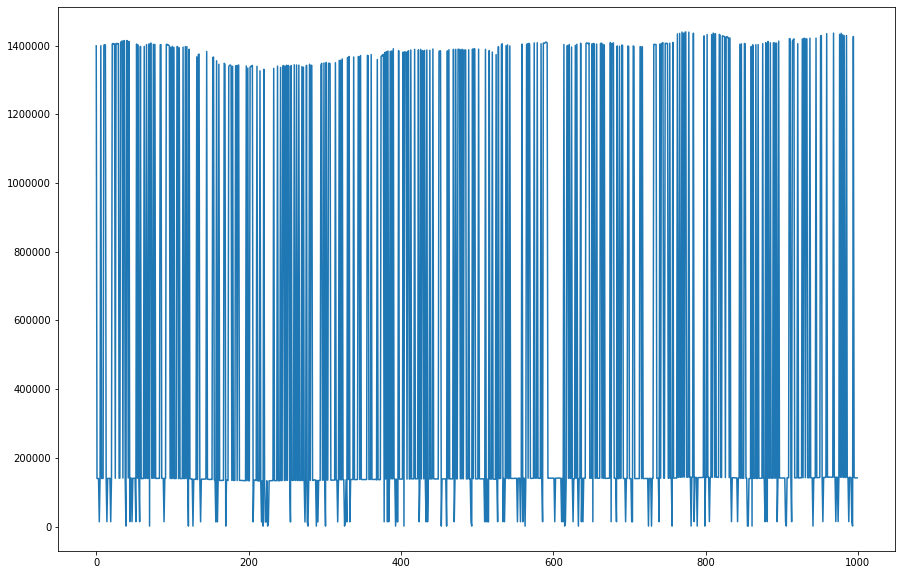

In [9]:
plt.figure(figsize = (15,10))
plt.plot(dataframe['close'])
plt.show()
plt.close()

### Grafico com a data correspodente

In [10]:
dataframe['timestamp'] = pd.to_datetime(dataframe["timestamp"], dayfirst=True)

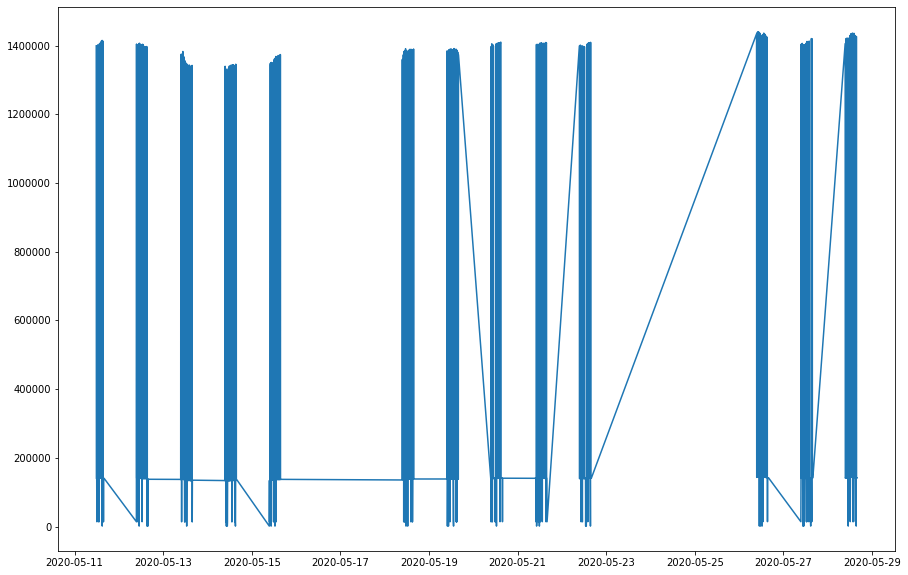

In [11]:
plt.figure(figsize = (15,10))
plt.plot(dataframe['timestamp'], dataframe['close'])
plt.show()
plt.close()

### Análisando durante semana

In [12]:
dataframe = dataframe.drop(["tradingDay"], axis=1)

dataframe['symbol'] = pd.factorize(dataframe['symbol'])[0] + 1

In [13]:
dataframe[0:5]

,symbol,timestamp,open,high,low,close,volume
0,1,2020-05-11 11:45:00,13996,13996,139829,1399037,7567
1,1,2020-05-11 11:50:00,139892,139939,1398323,139879,3968
2,1,2020-05-11 11:55:00,139891,139952,139846,139952,4819
3,1,2020-05-11 12:00:00,139906,139967,1399,139909,5142
4,1,2020-05-11 12:05:00,139943,139977,13981,13981,11500


In [14]:
dataframe.describe()

,symbol,open,high,low,close,volume
count,1000.0,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,1.0,4.396000e+05,3.608101e+05,3.566961e+05,5.028537e+05,11668.873000
std,0.0,5.532629e+05,5.040311e+05,5.006725e+05,5.851585e+05,16413.958367
min,1.0,1.335000e+03,1.336000e+03,1.339000e+03,1.330000e+03,1885.000000
25%,1.0,1.371145e+05,1.358150e+05,1.349555e+05,1.375618e+05,5846.000000
50%,1.0,1.403570e+05,1.403150e+05,1.399490e+05,1.405410e+05,8026.000000
75%,1.0,4.398490e+05,1.429055e+05,1.426028e+05,1.357773e+06,11364.000000
max,1.0,1.440096e+06,1.440005e+06,1.438216e+06,1.439565e+06,251891.000000


Qual valor aparece com mais frequencia

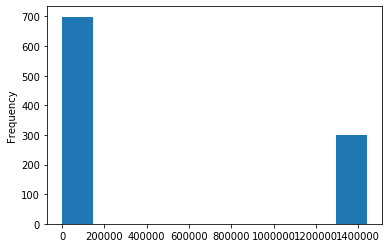

In [15]:
dataframe['close'].plot(kind="hist") 

### Análisado os dados com valor maior que 150mil

In [16]:
dataframe = dataframe[dataframe['close'] > 150000]

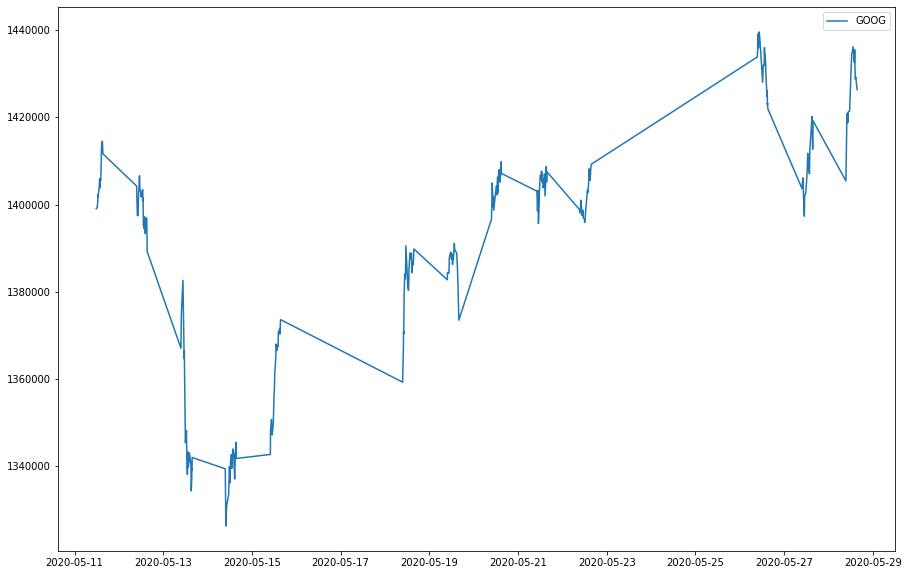

In [17]:
plt.figure(figsize = (15,10))
plt.plot(dataframe['timestamp'],dataframe['close'], label='GOOG')

plt.legend(loc='best')
plt.show()
plt.close()

## Configuração

In [18]:
look_back = 3 # Quanto dias atras será usado como base?
forward_days = 3 # qual dia depois de atualmente quero preve?
num_periods = 20 # Perido

lstmPrimeiraLayer = 64
lstmSegundaLayer = 32

nEpocas = 100
steps_per_epoch = 20
VALIDATION_SIZE = 1
BATCH_SIZE = 16
checkpoint = "bestLstmModel.hdf5"

## Pre-processamento

Pega somente o atributo close e transforma em um array

In [19]:
X = dataframe.drop(["close"], axis=1)
y = dataframe["close"]

array = dataframe["close"].values.reshape(dataframe["close"].shape[0],1)

In [20]:
array[0:5]

array([[1399037],
       [1399271],
       [1400775],
       [1402254],
       [1401685]], dtype=int64)

Separa em array de treino e teste

In [18]:
scl = MinMaxScaler()
array = scl.fit_transform(array)
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [19]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)


_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

Variaveis utilizado no treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Arquitetura
Arquitetura da rede é uma LSTM de duas camadas

In [21]:
model = Sequential()

model.add(LSTM(units=lstmPrimeiraLayer, input_shape=(look_back,1), return_sequences=True))

model.add(LSTM(units=lstmSegundaLayer,input_shape=(lstmPrimeiraLayer,1)))

model.add(Dense(units=forward_days, activation='linear'))



Train on 158 samples, validate on 78 samples
Epoch 1/100
20/20 [==============================] - 2s 79ms/step - loss: 0.4264 - mean_squared_error: 0.2262 - mean_absolute_error: 0.4264 - mean_absolute_percentage_error: 230275.9812 - cosine_proximity: -0.9741 - val_loss: 0.3085 - val_mean_squared_error: 0.1246 - val_mean_absolute_error: 0.3085 - val_mean_absolute_percentage_error: 537709.5625 - val_cosine_proximity: -0.9947

Epoch 00001: loss improved from inf to 0.42636, saving model to bestLstmModel.hdf5
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.1742 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1742 - mean_absolute_percentage_error: 1179474.0031 - cosine_proximity: -0.9932 - val_loss: 0.0919 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0919 - val_mean_absolute_percentage_error: 1481444.1250 - val_cosine_proximity: -0.9954

Epoch 00002: loss improved from 0.42636 to 0.17417, saving model to bestLstmModel.hdf5
Epoch 3/100
20/20

20/20 [==============================] - 0s 13ms/step - loss: 0.0371 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 545636.6750 - cosine_proximity: -0.9936 - val_loss: 0.0337 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0337 - val_mean_absolute_percentage_error: 570845.0000 - val_cosine_proximity: -0.9947

Epoch 00035: loss improved from 0.03755 to 0.03708, saving model to bestLstmModel.hdf5
Epoch 36/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0368 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 542371.9156 - cosine_proximity: -0.9936 - val_loss: 0.0335 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0335 - val_mean_absolute_percentage_error: 567185.0625 - val_cosine_proximity: -0.9945

Epoch 00036: loss improved from 0.03708 to 0.03678, saving model to bestLstmModel.hdf5
Epoch 37/100
20/20 [==============================] - 0s 13ms/step - lo

Epoch 53/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0355 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 557318.4938 - cosine_proximity: -0.9936 - val_loss: 0.0324 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0324 - val_mean_absolute_percentage_error: 567457.3750 - val_cosine_proximity: -0.9951

Epoch 00053: loss improved from 0.03560 to 0.03552, saving model to bestLstmModel.hdf5
Epoch 54/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0355 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 558346.8844 - cosine_proximity: -0.9936 - val_loss: 0.0324 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0324 - val_mean_absolute_percentage_error: 561168.5000 - val_cosine_proximity: -0.9951

Epoch 00054: loss did not improve from 0.03552
Epoch 55/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0356 - mean_squared_e

20/20 [==============================] - 0s 13ms/step - loss: 0.0353 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 561693.5062 - cosine_proximity: -0.9936 - val_loss: 0.0320 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0320 - val_mean_absolute_percentage_error: 559394.4375 - val_cosine_proximity: -0.9952

Epoch 00071: loss improved from 0.03527 to 0.03526, saving model to bestLstmModel.hdf5
Epoch 72/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0353 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 561373.2531 - cosine_proximity: -0.9936 - val_loss: 0.0318 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0318 - val_mean_absolute_percentage_error: 559981.3750 - val_cosine_proximity: -0.9952

Epoch 00072: loss did not improve from 0.03526
Epoch 73/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0354 - mean_squared_error: 0.0032 

20/20 [==============================] - 0s 12ms/step - loss: 0.0350 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 562506.4656 - cosine_proximity: -0.9937 - val_loss: 0.0314 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0314 - val_mean_absolute_percentage_error: 561989.3125 - val_cosine_proximity: -0.9952

Epoch 00089: loss improved from 0.03504 to 0.03503, saving model to bestLstmModel.hdf5
Epoch 90/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0350 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 561915.7094 - cosine_proximity: -0.9937 - val_loss: 0.0313 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0313 - val_mean_absolute_percentage_error: 553240.3125 - val_cosine_proximity: -0.9953

Epoch 00090: loss did not improve from 0.03503
Epoch 91/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0350 - mean_squared_error: 0.0032 

Metricas para análisa o desempenho do treino

In [ ]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['mse', 'mae', 'mape', 'cosine'])

Condição de parada e checkpoint

In [ ]:
mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)

In [ ]:
# fit the model
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

## Treinamento

In [ ]:
#batch_size = numero de execuções antes de atualizar os erros.
history = model.fit( X_train, y_train, epochs=nEpocas, steps_per_epoch=steps_per_epoch, callbacks=[es, mc], validation_steps = val_steps, validation_data=(X_test, y_test))

## Análise do treinamento

### Erro quadradico

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Erro absoluto

In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean_absolute_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Erro absoluto porcentual

In [ ]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Cosine aproximado

In [ ]:
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('cosine_proximity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Perca

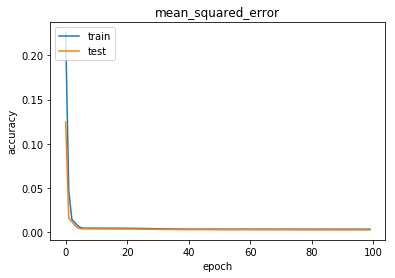

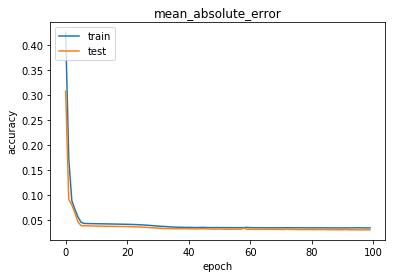

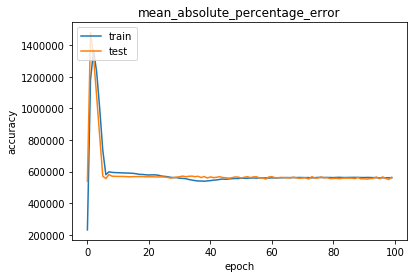

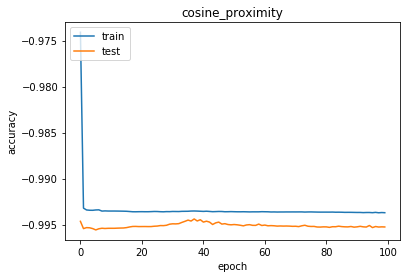

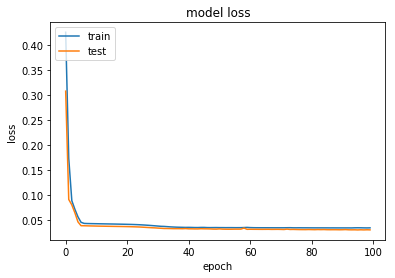

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Grafico do resultado predizido
Vermelho: predição
Azul: valor original

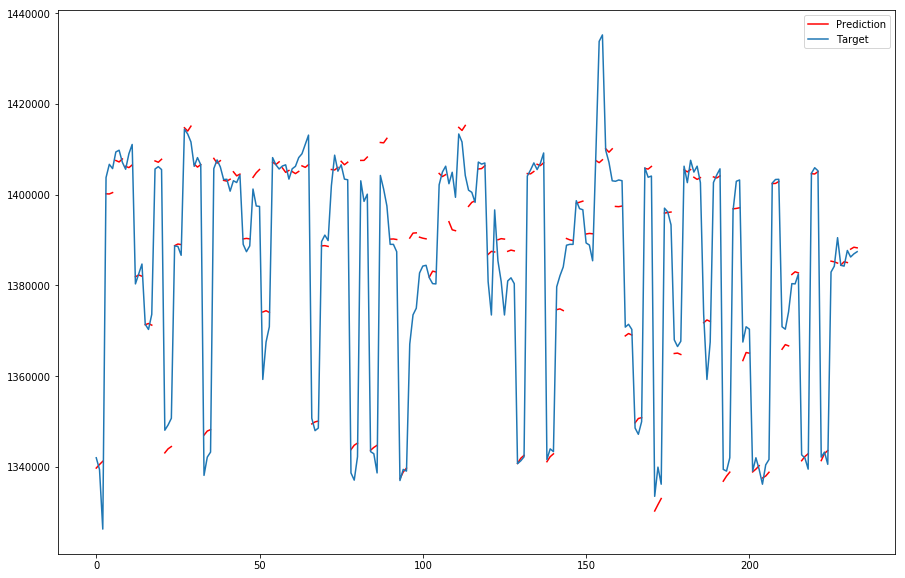

In [24]:
Xt = model.predict(X_test)
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') 
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

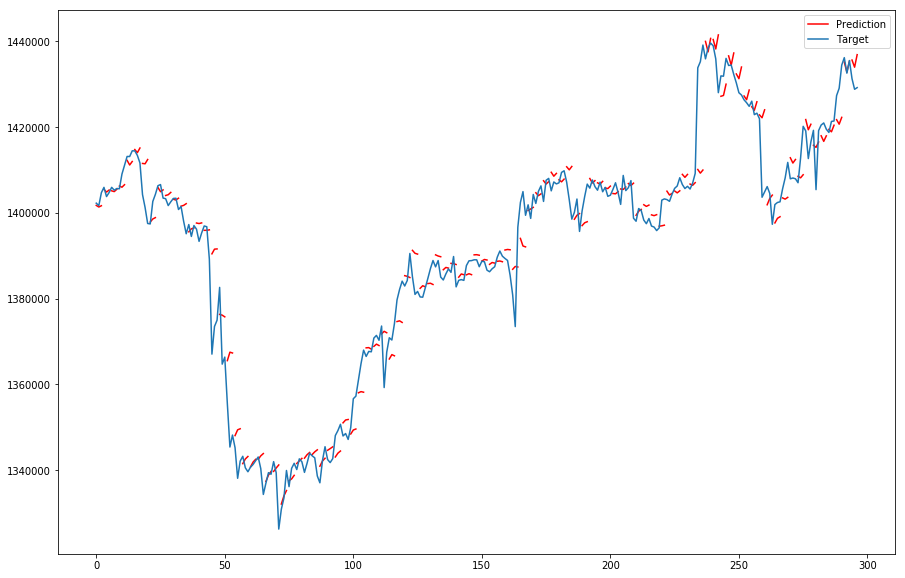

In [25]:
_data,y_data = processData(array,look_back,forward_days,forward_days)
Xt = model.predict(_data)
plt.figure(figsize = (15,10))
for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_data.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()


## Grafico dos dados utilizado durante o treinamento e teste

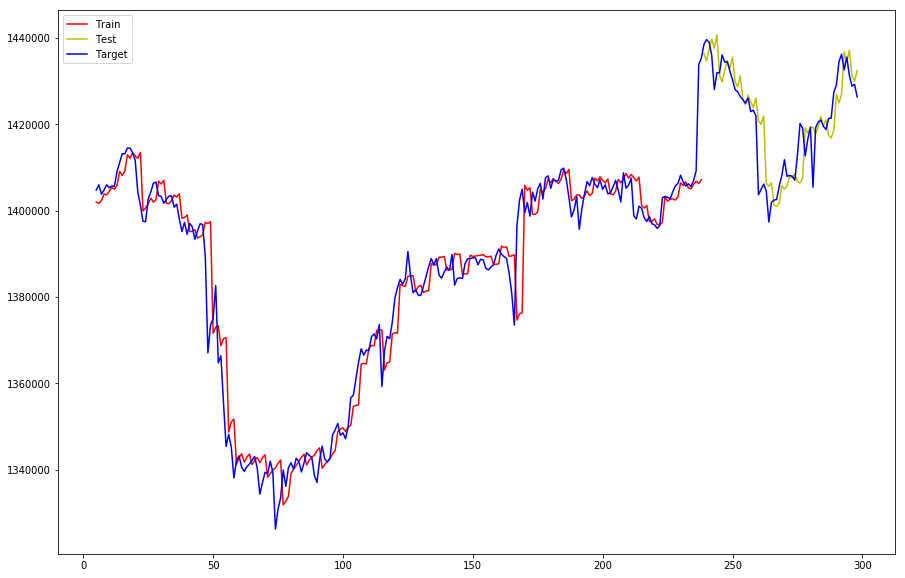

In [259]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

y = np.concatenate((ytrain, ytest), axis=0)
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()